In [1]:
# set up

from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot


## Survival Analysis

compute sf from cdf

In [3]:
import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1,3,4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')


In [4]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    
      """Makes a survival function based on a CDF.

    cdf: Cdf
    
    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

sf = MakeSurvivalFromCdf(cdf, label='survival')
print(cdf[13])
print(sf[13])

0.1397801412101171
0.8602198587898829


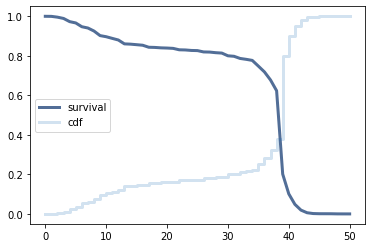

In [5]:
# Plot Cdf and SF

thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

In [6]:
# Hazard Function

hf = sf.MakeHazardFunction(label='hazard')
print(hf[39])

0.6767068273092369


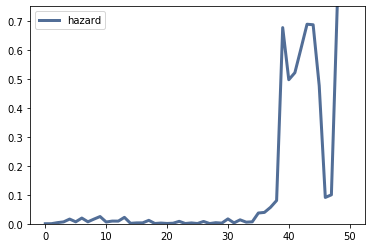

In [7]:
# meaning that of all those preg. reaching to week 39, 67% will end (give birth) at week 39

thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 0.75], loc='upper left')

## Age at first Marrige

use NSFG Data to estimate 
- hazard function and
- survival function for age at first marriage

In [9]:
# get data, clean data, convert date from century-month (15.Dec 1899) to years

resp6 = nsfg.ReadFemResp()

resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6['agemarry'] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6['age'] = (resp6.cmintvw - resp6.cmbirth) / 12.0

# extract age at first marrige (complete) and 2) age at interview who are not (ongoing)

complete = resp6[resp6.evrmarry==1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry==0].age

# estimation with Kaplan-Meier (first hazard from hazard to survival)

from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


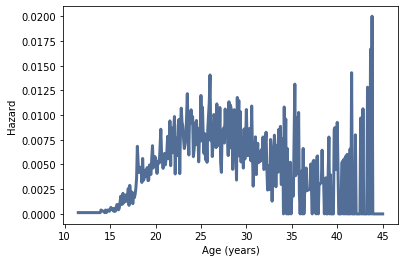

In [10]:
# Hazard Function

hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)', ylabel= 'Hazard')



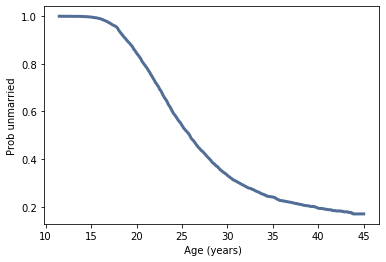

In [11]:
# Survival Function

sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel= ' Age (years)', ylabel= 'Prob unmarried')


In [24]:
# Quantifiying Uncertainty

# how much depend results on sampling error ? resampling

def EstimateMarriageSurvival(resp):
    
    # better fill missing values
    
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age
    
    hf = EstimateHazardFunction(complete, ongoing)
    
    sf = hf.MakeSurvival()
    
    return hf, sf

def ResampleSurvival(resp, iters=101):
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)
    
    
    #effect of sampling error
    
    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1/12.0)
    
    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))
        
    # calculate Percintle
    
    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='grey', label='90% CI')

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


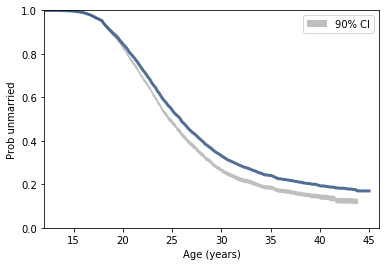

In [25]:
ResampleSurvival(resp6)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[12, 46],
                 ylim=[0, 1],
                 loc='upper right')

# 13.8  Cohort Effect


In [26]:

# combine all data

resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()
resps = [resp5, resp6, resp7]

def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateMarriageSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        # TODO: refactor this to collect resampled estimates and
        # plot shaded areas
        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

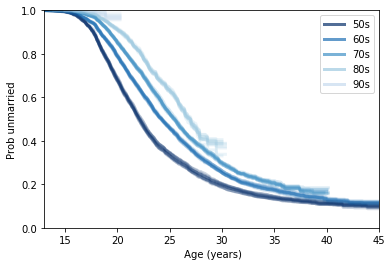

In [28]:
# results of combined data

PlotResampledByDecade(resps)
thinkplot.Config(xlabel = ' Age (years)',
                ylabel = 'Prob unmarried',
                xlim = [13, 45],
                ylim = [0, 1])



C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launche

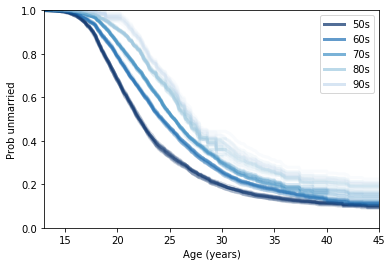

In [31]:
# 13.9 Extrapolation

# generating data for younger cohorts (borrowing data from older cohorts)
# assumption : each generation has same hazard function

def PlotPredictionsByDecade(groups, **options):
    
    hfs = []
    
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)
    
    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

PlotResampledByDecade(resps, predict_flag=True)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 xlim=[13, 45],
                 ylim=[0, 1])

In [32]:
# 13. 10 Expected remaining Lifetime

preg = nsfg.ReadFemPreg()

complete = preg.query('outcome in [1, 3, 4]').prglngth
print('Number of complete pregnancies', len(complete))
ongoing = preg[preg.outcome == 6].prglngth
print('Number of ongoing pregnancies', len(ongoing))

hf = EstimateHazardFunction(complete, ongoing)
sf1 = hf.MakeSurvival()

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


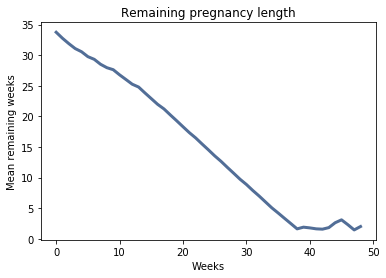

In [33]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(title='Remaining pregnancy length',
                 xlabel='Weeks',
                 ylabel='Mean remaining weeks')

# chart shows remaining weeks until delivery in weeks as a function of the number of elapsed weeks
# from week 36 on the process becomes 'memoryless' - not influenced by the past

C:\Users\ansve\anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


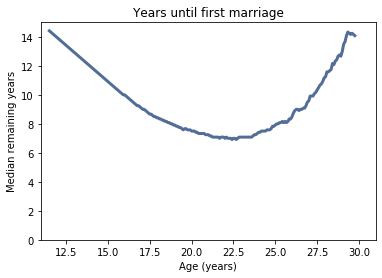

In [34]:
# Reaming years until first Marriage

hf, sf2 = EstimateMarriageSurvival(resp6)

func = lambda pmf: pmf.Percentile(50)

rem_life2 = sf2.RemainingLifetime(filler=np.inf, func=func)
    
thinkplot.Plot(rem_life2)
thinkplot.Config(title='Years until first marriage',
                 ylim=[0, 15],
                 xlim=[11, 31],
                 xlabel='Age (years)',
                 ylabel='Median remaining years')